# B-splines FEM solver for Poisson equation (2D)


In [14]:
# needed imports
from numpy import zeros, ones, linspace, zeros_like, asarray
from matplotlib.pyplot import plot, show
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from spaces import SplineSpace, TensorSpace
from linalg import StencilMatrix, StencilVector

In [3]:
# ... assembling the stiffness matrix using stencil forms
def assemble_stiffness(nelements, degree, spans, basis, weights, points, matrix):

    # ... sizes
    ne1,ne2              = nelements
    p1,p2                = degree
    spans_1, spans_2     = spans
    basis_1, basis_2     = basis
    weights_1, weights_2 = weights
    points_1, points_2   = points
    
    k1 = weights_1.shape[1]
    k2 = weights_2.shape[1]
    # ...

    # ... build matrices
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]        
        for ie2 in range(0, ne2):
            i_span_2 = spans_2[ie2]        
            # evaluation dependant uniquement de l'element
            
            for il_1 in range(0, p1+1):
                for il_2 in range(0, p2+1):                
                    for jl_1 in range(0, p1+1):
                        for jl_2 in range(0, p2+1):
                            i1 = i_span_1 - p1 + il_1
                            j1 = i_span_1 - p1 + jl_1

                            i2 = i_span_2 - p2 + il_2
                            j2 = i_span_2 - p2 + jl_2

                            v = 0.0
                            for g1 in range(0, k1):
                                for g2 in range(0, k2):
                                    bi_0 = basis_1[ie1, il_1, 0, g1] * basis_2[ie2, il_2, 0, g2]
                                    bi_x = basis_1[ie1, il_1, 1, g1] * basis_2[ie2, il_2, 0, g2]
                                    bi_y = basis_1[ie1, il_1, 0, g1] * basis_2[ie2, il_2, 1, g2]

                                    bj_0 = basis_1[ie1, jl_1, 0, g1] * basis_2[ie2, jl_2, 0, g2]
                                    bj_x = basis_1[ie1, jl_1, 1, g1] * basis_2[ie2, jl_2, 0, g2]
                                    bj_y = basis_1[ie1, jl_1, 0, g1] * basis_2[ie2, jl_2, 1, g2]

                                    wvol = weights_1[ie1, g1] * weights_2[ie2, g2]

                                    v += (bi_x * bj_x + bi_y * bj_y) * wvol

                            matrix[i1, i2, j1-i1, j2-i2]  += v
    # ...

    return matrix    
# ...

In [4]:
# ... Assembly procedure for the rhs
def assemble_rhs(f, nelements, degree, spans, basis, weights, points, rhs):

    # ... sizes
    ne1,ne2              = nelements
    p1,p2                = degree
    spans_1, spans_2     = spans
    basis_1, basis_2     = basis
    weights_1, weights_2 = weights
    points_1, points_2   = points
    
    k1 = weights_1.shape[1]
    k2 = weights_2.shape[1]
    # ...

    # ... build rhs
    for ie1 in range(0, ne1):
        i_span_1 = spans_1[ie1]        
        for ie2 in range(0, ne2):
            i_span_2 = spans_2[ie2]                        
            
            for il_1 in range(0, p1+1):
                for il_2 in range(0, p2+1):   
                    i1 = i_span_1 - p1 + il_1
                    i2 = i_span_2 - p2 + il_2                    

                    v = 0.0
                    for g1 in range(0, k1):
                        for g2 in range(0, k2):
                            bi_0 = basis_1[ie1, il_1, 0, g1] * basis_2[ie2, il_2, 0, g2]
                            bi_x = basis_1[ie1, il_1, 1, g1] * basis_2[ie2, il_2, 0, g2]
                            bi_y = basis_1[ie1, il_1, 0, g1] * basis_2[ie2, il_2, 1, g2]
                            
                            x1    = points_1[ie1, g1]
                            x2    = points_2[ie2, g2]
                            wvol  = weights_1[ie1, g1]*weights_2[ie2, g2]

                            v += bi_0 * f(x1,x2) * wvol

                    rhs[i1,i2] += v
    # ...

    # ...
    return rhs
    # ...
# ...

In [5]:
V1 = SplineSpace(degree=2, nelements=4)
V2 = SplineSpace(degree=2, nelements=4)

V = TensorSpace(V1, V2)

In [45]:
stiffness = StencilMatrix(V.vector_space, V.vector_space)
stiffness = assemble_stiffness(V.nelements, 
                               V.degree, 
                               V.spans, 
                               V.basis, 
                               V.weights, 
                               V.points, 
                               matrix=stiffness)

In [46]:
rhs = StencilVector(V.vector_space)

f = lambda x,y: 2*x*(1 - x) + 2*y*(1 - y) 
rhs = assemble_rhs(f, 
                   V.nelements, 
                   V.degree, 
                   V.spans, 
                   V.basis, 
                   V.weights, 
                   V.points, 
                   rhs=rhs)

In [47]:
n1,n2 = V.nbasis

rhs[0,:]    = 1.
rhs[n1-1,:] = 1.
rhs[:,0]    = 1.
rhs[:,n2-1] = 1.

stiffness[0,:,0,:]    = 1.e14
stiffness[n1-1,:,0,:]    = 1.e14
stiffness[:,0,:,0]    = 1.e14
stiffness[:,n2-1,:,0]    = 1.e14

In [48]:
# convert the stencil matrix to scipy sparse
stiffness = stiffness.tosparse() 

In [49]:
rhs = rhs.toarray()

In [50]:
from scipy.sparse import csc_matrix, linalg as sla

lu = sla.splu(csc_matrix(stiffness))
x = lu.solve(rhs)

In [51]:
x

array([-2.12673611e-16,  3.55902778e-17,  2.54692819e-14, -1.48954971e-14,
        3.55902778e-17, -2.12673611e-16,  3.55902778e-17,  1.56250000e-02,
        3.12500000e-02,  3.12500000e-02,  1.56250000e-02,  3.55902778e-17,
       -1.48954971e-14,  3.12500000e-02,  6.25000000e-02,  6.25000000e-02,
        3.12500000e-02,  2.54692819e-14,  2.54692819e-14,  3.12500000e-02,
        6.25000000e-02,  6.25000000e-02,  3.12500000e-02, -1.48954971e-14,
        3.55902778e-17,  1.56250000e-02,  3.12500000e-02,  3.12500000e-02,
        1.56250000e-02,  3.55902778e-17, -2.12673611e-16,  3.55902778e-17,
       -1.48954971e-14,  2.54692819e-14,  3.55902778e-17, -2.12673611e-16])

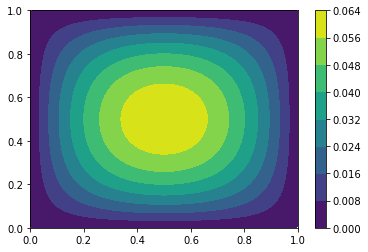

In [52]:
from utilities import plot_field_2d

u = x.reshape(V.nbasis)
plot_field_2d(V.knots, V.degree, u) ; plt.colorbar()

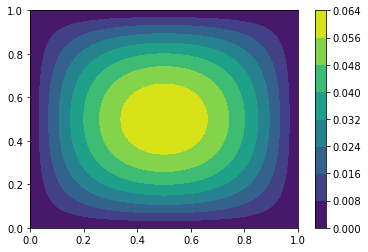

In [53]:
import numpy as np

N = 200
ts = np.linspace(0.,1.,N)
X,Y = np.meshgrid(ts,ts)
f = lambda x,y: x*(1-x)*y*(1-y)
Z = [[f(x,y) for x in ts] for y in ts]
plt.contourf(X,Y,Z); plt.colorbar()